<div class="alert alert-block alert-success">
FASE 1: CARGA DE DATOS, TRATAMIENTO, LIMPIADO Y CREACIÓN DE DATAFRAME FINAL
<br><br>FASE 2: ANÁLISIS VARIABLES, FEATURES SELECTION
<br><br>FASE 3: DEFINICIÓN FUNCIONES MACHINE LEARNING Y APLICACIÓN DE MODELOS
<br><br>FASE 4: CONCLUSIONES
</div>

<div class="alert alert-block alert-success">
FASE 1
</DIV>

<div class="alert alert-block alert-info"> 
LIBRERIAS
</div>

In [4]:
import pandas as pd
import numpy as np
import time, datetime
import math
import warnings
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, cross_validation, svm
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

#METRICAS
from sklearn import metrics 

# FEATURES SELECTION
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

#from sklearn.model_selection import TimeSeriesSplit

C:\Users\juan.roncero\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
%pylab inline
%matplotlib inline
style.use('ggplot')
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-block alert-info">
CARGA DE DATOS
</div>

In [6]:
# FICHERO ALOJADO EN http://dreamlife.es\ripple29Mayo.csv
ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\ripple29Mayo.csv"
#ruta = "http://dreamlife.es/ripple.csv"
dfTransacciones = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\ballenas.csv"
#ruta = "http://dreamlife.es/ballenas.csv"
dfTransBallenas = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\tweets.csv"
#ruta = "http://dreamlife.es/tweets.csv"
dfTweets = pd.read_csv(ruta,delimiter=";", decimal=",")

<div class="alert alert-block alert-info">
TRATAMIENTO DE DATOS
</div> 

In [7]:
# TRANSFORM
dfTransacciones["FECHA"] = pd.to_datetime(dfTransacciones["FECHA"])
dfTransacciones.index = pd.to_datetime(dfTransacciones["FECHA"], unit='s')
dfTransacciones = dfTransacciones.sort_values('FECHA')

dfTransBallenas["FECHA"] = dfTransBallenas["FECHA_OPERACION"]
dfTransBallenas["FECHA"] = pd.to_datetime(dfTransBallenas["FECHA"])
dfTransBallenas.index = pd.to_datetime(dfTransBallenas["FECHA"], unit='s')
dfTransBallenas = dfTransBallenas.sort_values('FECHA')

dfTweets["FECHA"] = pd.to_datetime(dfTweets["FECHA"])
dfTweets.index = pd.to_datetime(dfTweets["FECHA"], unit='s')
dfTweets = dfTweets.sort_values('FECHA')
dfTweets = dfTweets[dfTweets["ID_CUENTA"]==1]

<div class="alert alert-block alert-info">
VARIABLE GLOBAL USADA PARA PODER PROBAR DIFERENTES AGRUPADOS DE TIEMPO DE LOS 3 TIPOS DE DATAFRAME:
<BR><BR>
- Transacciones de usuarios
<BR><BR>
- Transacciones de ballenas (>1.000.000)
<BR><BR>
- Tweets
</div> 

In [8]:
minutosDeAgrupado = 5

<div class="alert alert-block alert-info"> 
FUNCIONES PARA AGRUPAR LOS DATAFRAMES POR TIEMPO
<br><BR>
(Reciben como parámetro el dataframe y el número de minutos)
</div>

In [9]:
def agrupaTweets(df, minutos):
    
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).mean()
    df1 = df1["SENTIMIENTO"]
    
    return df1

def agrupaBallenas(df, minutos):
    
    df['CANTIDAD_TOTAL'] = df["CANTIDAD"]
        
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df1["NUM_TRANSACCIONES"] = df1['CANTIDAD']
    df1 = df1["NUM_TRANSACCIONES"] 
    
    df2 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df2 = df2['CANTIDAD_TOTAL']
    
    df = pd.concat([df1, df2],axis=1)
    
    return df

def agrupaDatos(df, minutos):
    
    #df = dfTransacciones
    dfCompras = df[df["TIPOTRANSACCION"]==False]
    dfVentas = df[df["TIPOTRANSACCION"]==True]

    # NUEVAS COLUMNAS
    df["HIGH"] = df["PRICE"]
    df['LOW'] = df["PRICE"]
    df['CANTIDAD_TOTAL'] = df["AMOUNT"]
    dfCompras['NUM_T_COMPRA'] = dfCompras["AMOUNT"]
    dfVentas['NUM_T_VENTA'] = dfVentas["AMOUNT"]

    # MAXIMO, MINIMO, CANTIDAD_TOTAL
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).agg({'HIGH':np.max, 'LOW':np.min,'CANTIDAD_TOTAL':np.sum})

    # NÚMERO DE TRANSACCIONES DE COMPRA
    df2 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df2 = df2['NUM_T_COMPRA']

    # NÚMERO DE TRANSACCIONES DE VENTA
    df3 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df3 = df3['NUM_T_VENTA']

    # CANTIDAD TOTAL DE MONEDA COMPRADA
    df4 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum() 
    df4["CANTIDAD_COMPRA"] = df4['AMOUNT']
    df4 = df4['CANTIDAD_COMPRA']

    # CANTIDAD TOTAL DE MONEDA VENDIDA
    df5 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df5["CANTIDAD_VENTA"] = df5['AMOUNT']
    df5 = df5['CANTIDAD_VENTA']

    # OPEN
    df6 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).first()
    df6["OPEN"] = df6["PRICE"]
    df6= df6["OPEN"]

    # CLOSE
    df7 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).last()
    df7["CLOSE"] = df7["PRICE"]
    df7= df7["CLOSE"]

    df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)

    # NUEVAS COLUMNAS CALCULADAS
    df['VAR_MAX'] = (df['HIGH'] - df['LOW'])/df['LOW'] * 100
    df['VAR_INTERVALO'] = (df['CLOSE'] - df['OPEN'])/df['OPEN'] * 100

    # FILTRAMOS COLUMNAS 
    df = df[['NUM_T_COMPRA','NUM_T_VENTA','CANTIDAD_COMPRA','CANTIDAD_VENTA','VAR_MAX','VAR_INTERVALO','OPEN', 'CLOSE']]

    df = df.dropna()
    
    return df

<div class="alert alert-block alert-info"> 
AGRUPAMOS LOS 3 DATAFRAMES
</div>

In [10]:
dfAgrupadoUsuarios = agrupaDatos(dfTransacciones, minutosDeAgrupado)
dfAgrupadoTweets = agrupaTweets(dfTweets, minutosDeAgrupado)
dfAgrupadoBallenas = agrupaBallenas(dfTransBallenas, minutosDeAgrupado)

<div class="alert alert-block alert-info"> 
CREAMOS DOS FEATURES NUEVAS PARA MEDIR LA TENSIÓN DEL MERCADO EN EL DATAFRME DE TRANSACCIONES
</div>


In [11]:
dfAgrupadoUsuarios["TENDENCIA_SUBIDA_ACUMULADA"] = 0 # 0-N FLOAT REGISTRA LA ACUMULACIÓN DE SUBIDA EN %
dfAgrupadoUsuarios["TENDENCIA_BAJADA_ACUMULADA"] = 0 # 0-N FLOAT REGISTRA LA ACUMULACIÓN DE BAJADA EN %

numColTendenciaSubida = 8
numColTendenciaBajada = 9

acumuladoSubida = 0
acumuladoBajada = 0
primeraSubida = True
primeraBajada = True

cont = 0

contDebugSub = 0
contDebugBaj = 0

for index, row in dfAgrupadoUsuarios.iterrows():
       
        # SI SUBE EL PRECIO
        if(row['VAR_INTERVALO'] > 0):      
            
            contDebugSub+=1
            
            if(primeraSubida):
                acumuladoBajada = 0
                primeraBajada = True
                primeraSubida = False
            
            acumuladoSubida += row['VAR_INTERVALO']
            dfAgrupadoUsuarios.iloc[cont,numColTendenciaSubida] = acumuladoSubida                                                
            
        # SI BAJA EL PRECIO
        else:             
            
            contDebugBaj+=1
            
            if(primeraBajada): 
                acumuladoSubida = 0
                primeraSubida = True
                primeraBajada = False
            
            acumuladoBajada += -row['VAR_INTERVALO']
            dfAgrupadoUsuarios.iloc[cont,numColTendenciaBajada] = acumuladoBajada                
           
        cont+=1
        

<div class="alert alert-block alert-info"> 
CREAMOS FEATURES NUEVAS EN FUNCIÓN DE LOS VALORES DE REGISTROS ANTERIORES
</div>

In [12]:
#########################################
######### VARIABLES ENTRADA #############
#########################################
numeroRegAnteriores = 5

dfFinal = dfAgrupadoUsuarios

for i in range(1, numeroRegAnteriores+1):
    dfAux =  dfAgrupadoUsuarios.shift(i)
    etiqueta = '_t(' + str(i) + ')'
    dfAux.columns = ['NUM_T_COMPRA' + etiqueta,
                    'NUM_T_VENTA' + etiqueta,
                    'CANTIDAD_COMPRA'  + etiqueta,
                    'CANTIDAD_VENTA' + etiqueta, 
                    'VAR_MAX' + etiqueta,
                    'VAR_INTERVALO' + etiqueta,
                    'OPEN' + etiqueta,
                    'CLOSE' + etiqueta,
                    'TENDENCIA_SUBIDA_ACUMULADA' + etiqueta,
                    'TENDENCIA_BAJADA_ACUMULADA' + etiqueta]
    dfFinal = pd.concat([dfFinal, dfAux], axis=1)


<div class="alert alert-block alert-info"> 
JUNTAMOS LOS 3 DATAFRAMES (DE MOMMENTO NO, YA QUE NO COINCIDEN TEMPORALMENTE Y QUEDAN POCOS REGISTROS FINALES AL HACER DROP
</div>

<div class="alert alert-block alert-info"> 
CREAMOS VARIABLE A PRONOSTICAR
</div>

In [14]:
#numero de intervalos del horizonte
numIntervarlosHorizonte = 3

precioFuturo = dfFinal['CLOSE'].shift(-numIntervarlosHorizonte)
precioActual = dfFinal['CLOSE']

dfFinal['PRONOSTICO'] = (precioFuturo - precioActual) / precioActual * 100
dfFinal = dfFinal.dropna()

<div class="alert alert-block alert-success">
FASE 2 - FEATURES SELECTION
</div>

<div class="alert alert-block alert-info"> 
2.1 Univariate Selection
</div>

In [15]:
dfTemp = dfFinal.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
numpy.set_printoptions(precision=3)

print(fit.scores_)

[  43.176  398.331   84.617  230.004  131.161  168.341    0.676    0.514
   47.635]


<div class="alert alert-block alert-info"> 
2.2 Recursive Feature Elimination
</div>

In [16]:
dfTemp = dfFinal.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')

model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)

print("Num Features:" , fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

Num Features: 4
Selected Features: [False  True False False  True  True False False  True]
Feature Ranking: [6 1 2 5 1 1 4 3 1]


<div class="alert alert-block alert-info"> 
2.3 Recursive Feature Elimination
</div>

In [17]:
dfTemp = dfFinal.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.101  0.148  0.097  0.11   0.13   0.147  0.09   0.089  0.088]


<div class="alert alert-block alert-success">
FASE 3 - MACHINE LEARNING
</div>

<div class="alert alert-block alert-info"> 
ML - FUNCIONES 
</div>

In [18]:
def calculaMetricas(y_test, y_pred):
    
    mae =  metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return mae, mse, rmse
     
def mensajeAlgoritmo(start, nombre):
    
    segundos = time.time() - start
    if(segundos < 1):
          mensaje = nombre + " PROCESADO EN < 1 seg"
    else:
          mensaje = nombre + " PROCESADO EN " + str(time.time() - start) + " seg."              

    return mensaje


# ENUMERADOR DE ALGORITMOS
class modeloRegresion:
    
    LinearRegresion,Ridge,SVMLinear,SVMPoly, SVMRbf, XGBRegressorLinear, DecisionTreeRegressor  = range(7)
    
def train_test_split(df, nombreColumna, test_size=0.1):
    
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    
    x_ent = np.array(train_data.drop([nombreColumna],1)) 
    x_ent = preprocessing.scale(x_ent)
    x_test = np.array(test_data.drop([nombreColumna],1))
    x_test = preprocessing.scale(x_test)
    
    y_ent = np.array(train_data[nombreColumna]) 
    y_test = np.array(test_data[nombreColumna]) 
    
    return x_ent, x_test, y_ent, y_test

<div class="alert alert-block alert-info"> 
FUNCIONES DE ALGORITMOS DE MACHINE LEARNING
</div>

In [26]:
def obtenerModelo(df, nombreColumnaLabel,tipo):
    
    x_ent, x_test, y_ent, y_test = train_test_split(df,nombreColumnaLabel,test_size=0.2)    

    if(tipo==modeloRegresion.LinearRegresion):                 
        nombre = "LinearRegresion"
        modelo = LinearRegression()        
    if(tipo==modeloRegresion.Ridge):         
        nombre = "Ridge"
        modelo = Ridge()  
    if(tipo==modeloRegresion.SVMLinear): 
        nombre = "SVM_Linear"
        modelo = svm.SVR(kernel='linear', C=1e3)  
    if(tipo==modeloRegresion.SVMPoly): 
        nombre = "SVM_Poly"
        modelo = svm.SVR(kernel='poly', C=1e3,degree=2) 
    if(tipo==modeloRegresion.SVMRbf): 
        nombre = "SVM_Rbf"
        modelo = svm.SVR(kernel='SVMRbf', C=1e3, gamma=0.1)  
    if(tipo==modeloRegresion.XGBRegressorLinear): 
        nombre = "XGB_Linear"
        modelo = xgb.XGBRegressor(max_depth=3, min_child_weight=10, subsample=0.5,
                colsample_bytree=0.6, objective='reg:linear', n_estimators=1000,
                learning_rate=0.3)  
    if(tipo==modeloRegresion.DecisionTreeRegressor):                 
        nombre = "DecisionTreeRegressor"
        modelo = DecisionTreeRegressor(random_state=1)
        
    modelo.fit(x_ent,y_ent)   
    y_pred = modelo.predict(x_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred) 
    
    resultadoModelo = [nombre, mae,mse,rmse,''] 

    return resultadoModelo,  x_ent, x_test, y_ent, y_test, y_pred


In [27]:
def obtenerModelos(df, nombreColumnaLabel):
    
    dfResultados = pd.DataFrame(columns=('ALGORITMO','MAE','MSE','RMSE','PARÁMETROS'))  

    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.LinearRegresion)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.Ridge)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    #resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMLinear)
    #dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    #resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMPoly)
    #dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    #resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMRbf)
    #dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.XGBRegressorLinear)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.DecisionTreeRegressor)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    return dfResultados


<div class="alert alert-block alert-info"> 
FUNCIONES DE VISUALIZACION
</div>

In [23]:
def pintaDatos(df):

    test_size=0.1
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]

    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(train_data.CLOSE, label="DATOS DE ENTRENAMIENTO", linewidth=2)
    ax.plot(test_data.CLOSE, label="DATOS DE TEST", linewidth=2)
    ax.set_ylabel('PRECIO [XRP]', fontsize=14)
    ax.set_title("PREPARACION DE DATOS", fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
def pintaPrecioPrediccion(df):
    
    split_row = len(dfFinal) - int(0.2 * len(dfFinal))
    train_data = dfFinal.iloc[:split_row]
    test_data = dfFinal.iloc[split_row:]

    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(dfFinal.index, dfFinal["CLOSE"], label="PRECIO REAL", linewidth=2)
    ax.plot(test_data.index, test_data["CLOSE"] + y_pred * test_data["CLOSE"] / 100, label="PREDICCIÓN", linewidth=2)
    ax.set_ylabel('PRECIO [XRP]', fontsize=14)
    ax.set_title("COMPARACIÓN DE PRECIO REAL VS PREDICCIÓN", fontsize=18)
    ax.legend(loc='best', fontsize=18)

def pintaPorcentajes(y_test,y_pred):
    
    pylab.rcParams['figure.figsize'] = (30, 20)
    plt.plot(y_test,color='lightblue')
    plt.plot(y_pred)
    plt.show()

<div class="alert alert-block alert-info"> 
ENTRENAMIENTO / TEST
</div>

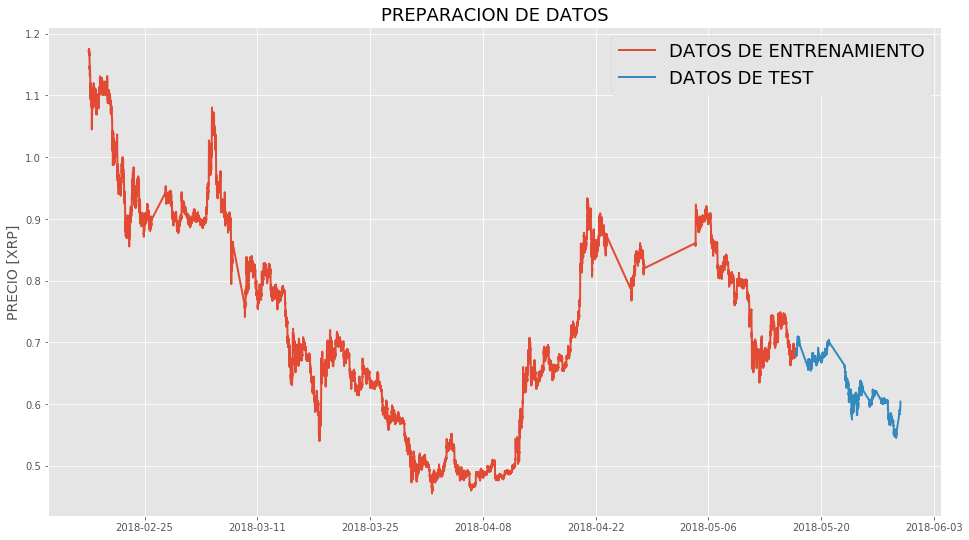

In [24]:
pintaDatos(dfFinal)

<div class="alert alert-block alert-info"> 
LINEAR REGRESION - RESULTADO / TEST - GRÁFICA DE PRECIOS VS PREDICCIÓN
</div>

In [211]:
resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.LinearRegresion)

<div class="alert alert-block alert-info"> 
PINTAMOS EL VALOR DEL RESULTADO REAL Y LA PREDICCIÓN (% de valor de subida/bajada)
</div> 

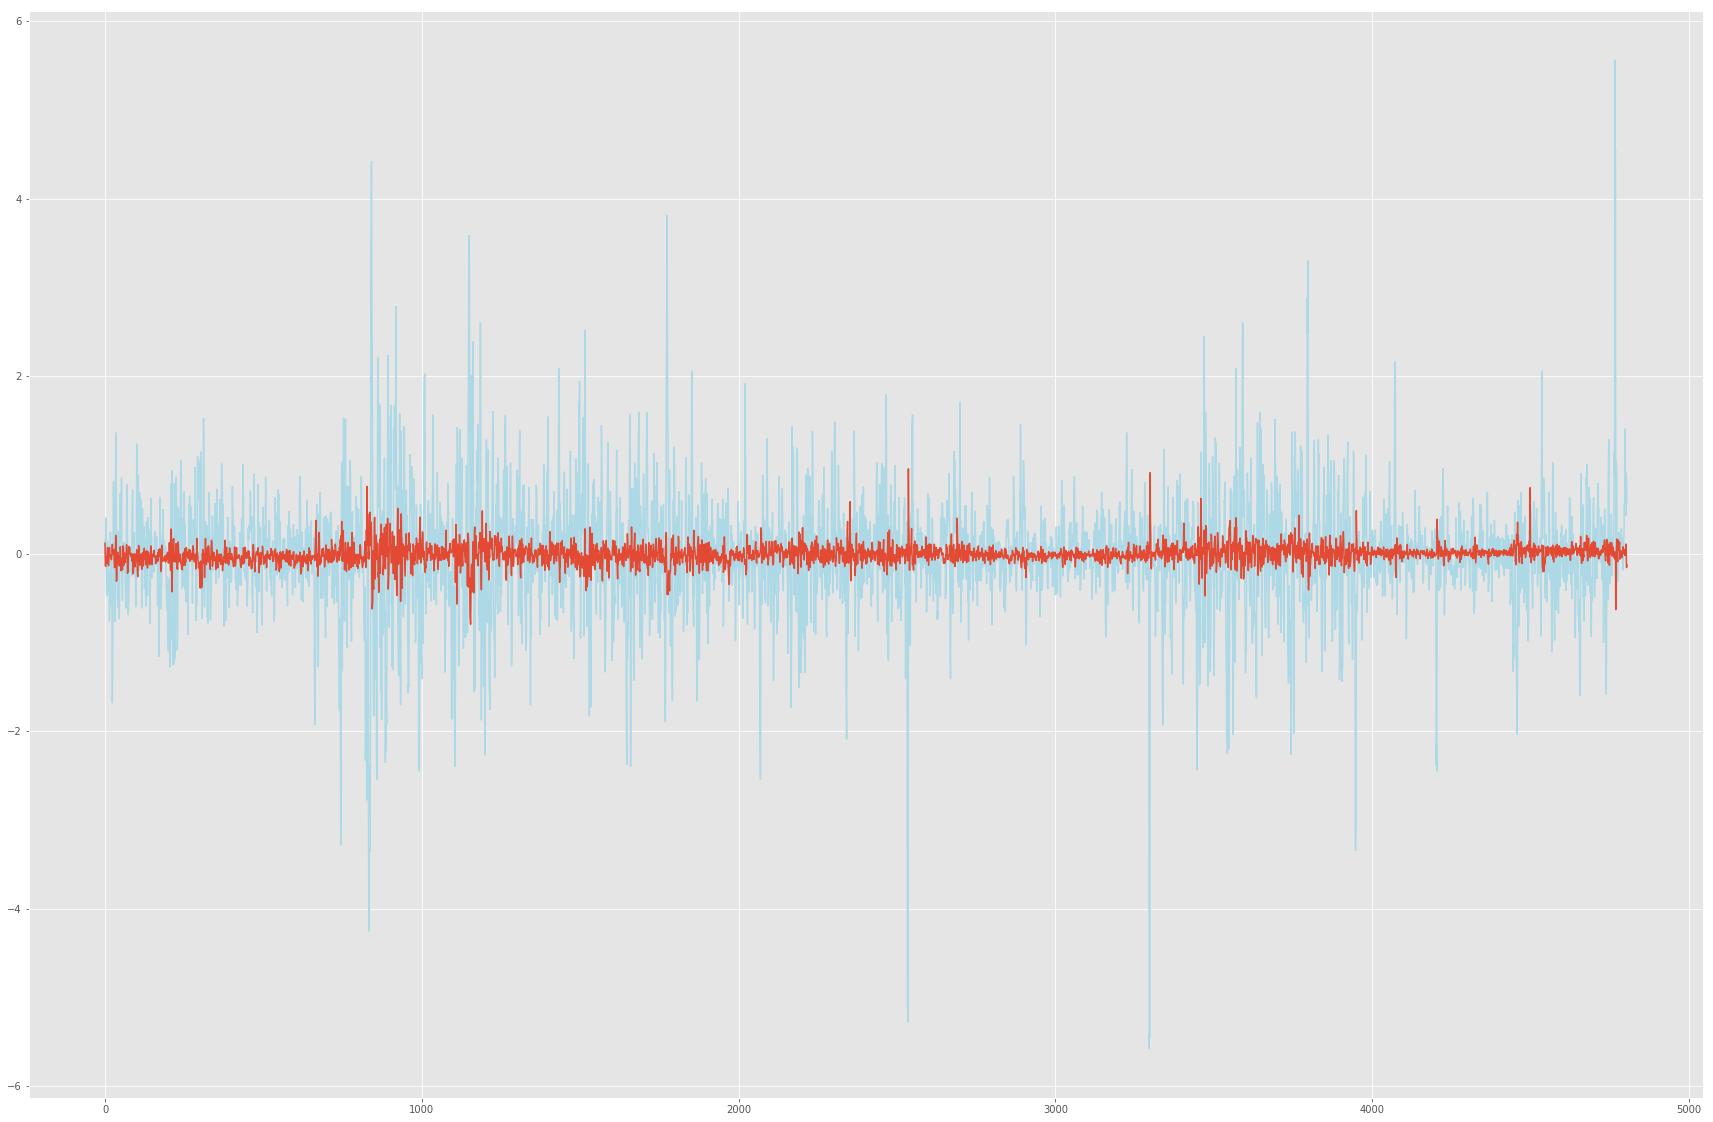

In [212]:
pintaPorcentajes(y_test, y_pred)

<div class="alert alert-block alert-info"> 
LINEAR REGRESION - RESULTADO / TEST - GRÁFICA DE PRECIOS VS PREDICCIÓN
<br/><br> En el segundo caso hacemos zoom sobre la parte de predicción
</div>

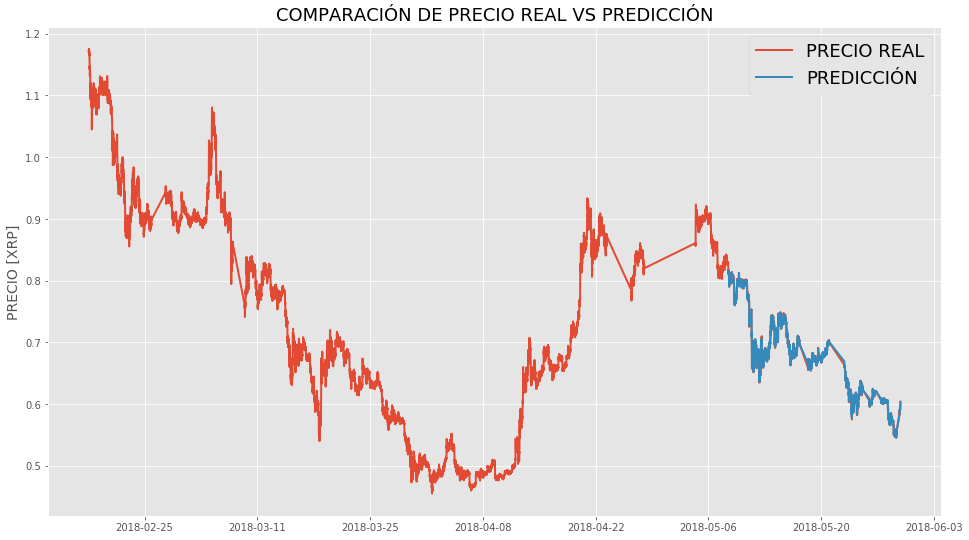

In [213]:
pintaPrecioPrediccion(dfFinal)

<div class="alert alert-block alert-info"> 
RIDGE - RESULTADO / TEST - GRÁFICA DE PRECIOS VS PREDICCIÓN
</div>

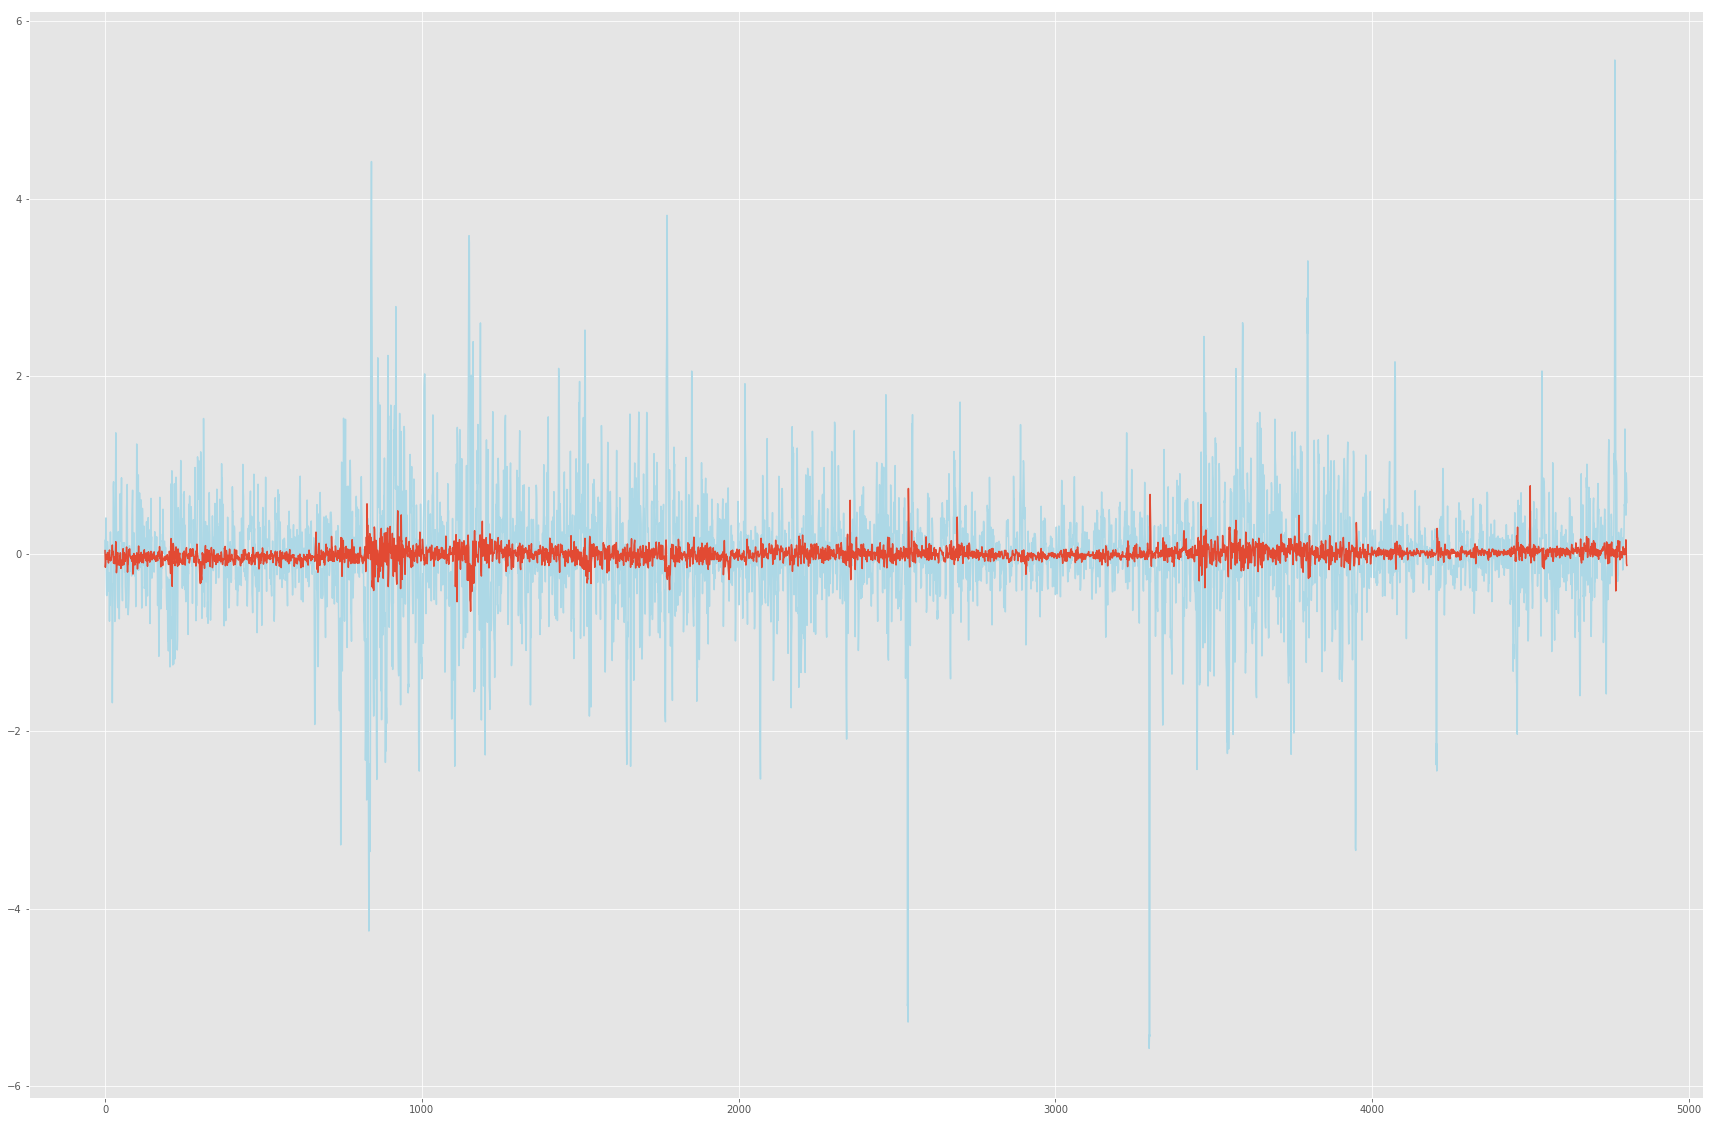

In [214]:
resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.Ridge)
pintaPorcentajes(y_test, y_pred)

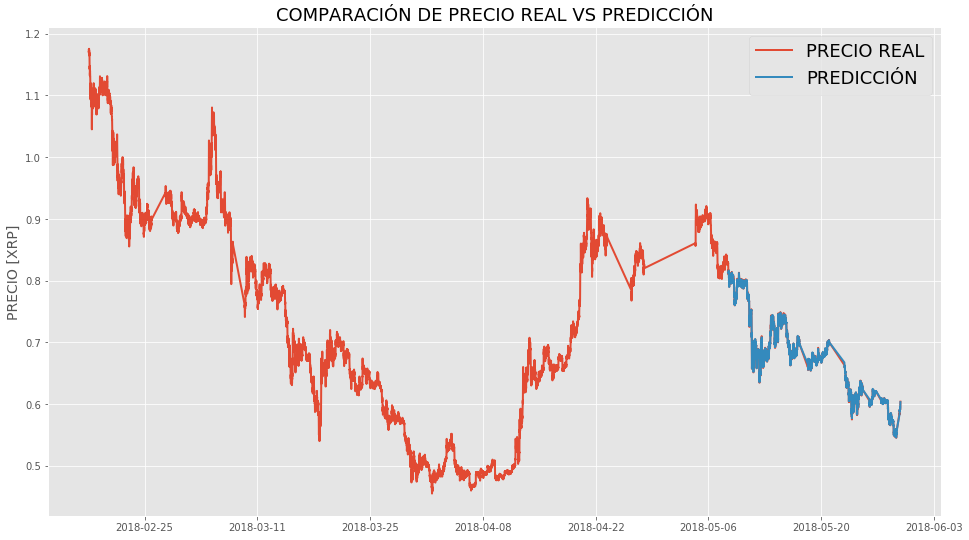

In [215]:
pintaPrecioPrediccion(dfFinal)

<div class="alert alert-block alert-info"> 
CON LA SIGUIENTE LLAMADA, PODEMOS OBTENER EL RESULTADO DE TODAS LAS MÉTRICAS ESTUDIADAS PARA CADA UNO DE LOS ALGORITMOS REGRESORES
</div>

In [28]:
obtenerModelos(dfFinal,"PRONOSTICO")

,ALGORITMO,MAE,MSE,RMSE,PARÁMETROS
0,LinearRegresion,0.442623,0.461325,0.679209,
1,Ridge,0.442466,0.457633,0.676486,
2,XGB_Linear,0.641009,0.869240,0.932330,
3,DecisionTreeRegressor,0.885269,1.891081,1.375166,
